# Advanced Enhanced Imaging with Aurora SDK

This notebook demonstrates advanced Enhanced Imaging capabilities, building on the basics covered in `04_enhanced_imaging.ipynb`.

## Advanced Topics Covered:

### 🔬 **Advanced Multi-Modal Correlation**
- Temporal synchronization analysis
- Pixel-level depth-segmentation mapping
- Rectified camera image correlation

### 📐 **Geometric Rectification**
- SDK-based rectified segmentation alignment
- Camera-to-depth coordinate mapping
- Pixel-perfect geometric correlation

### 🌈 **Depth-Based Visualization**
- Segmentation objects colored by average depth values
- 3D semantic understanding
- Multi-modal overlay techniques

### 📊 **Advanced Analytics**
- Statistical analysis of multi-modal data
- Boundary detection and visualization
- Comprehensive correlation metrics

**Prerequisites:** Complete `04_enhanced_imaging.ipynb` first to understand the basics, including alternative model usage.

## Setup and Imports

In [20]:
# Core imports
from slamtec_aurora_sdk import AuroraSDK
from slamtec_aurora_sdk.exceptions import DataNotReadyError
from slamtec_aurora_sdk.data_types import ENHANCED_IMAGE_TYPE_DEPTH, ENHANCED_IMAGE_TYPE_SEMANTIC_SEGMENTATION
from slamtec_aurora_sdk.data_types import DEPTHCAM_FRAME_TYPE_DEPTH_MAP, DEPTHCAM_FRAME_TYPE_POINT3D
from slamtec_aurora_sdk.utils import to_numpy_segmentation_map, get_colorized_segmentation, generate_class_colors

import numpy as np
import time
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Configure matplotlib for notebook
try:
    get_ipython().run_line_magic('matplotlib', 'inline')
except:
    pass
plt.rcParams['figure.figsize'] = (18, 12)

print("🚀 Advanced Enhanced Imaging notebook ready!")

🚀 Advanced Enhanced Imaging notebook ready!


In [ ]:
# Device connection and setup
device_ip = "192.168.11.1"  # Replace with your device IP

sdk = AuroraSDK()

try:
    print(f"Connecting to Aurora device at {device_ip}...")
    sdk.connect(connection_string=device_ip)
    print("✅ Connected successfully!")
    
    # Enable Enhanced Imaging subscriptions
    sdk.controller.set_enhanced_imaging_subscription(ENHANCED_IMAGE_TYPE_DEPTH, True)
    sdk.controller.set_enhanced_imaging_subscription(ENHANCED_IMAGE_TYPE_SEMANTIC_SEGMENTATION, True)
    print("✅ Enhanced Imaging subscriptions enabled")
    
    # Initialize label info with default values
    label_info = None
    label_set_name = "Default"
    
    # Get current model info (default or previously set alternative)
    try:
        label_info = sdk.enhanced_imaging.get_semantic_segmentation_labels()
        label_set_name = sdk.enhanced_imaging.get_semantic_segmentation_label_set_name()
        current_model = sdk.enhanced_imaging.is_semantic_segmentation_alternative_model()
        model_type = "Alternative" if current_model else "Default"
        print(f"🏷️ Using {model_type} Model: {label_set_name} ({label_info.label_count} classes)")
    except Exception as e:
        print(f"⚠️ Could not get model info: {e}")
        print("🔧 Will use fallback label configuration during colorization")
    
    # Wait for data readiness
    time.sleep(3)
    print("✅ Ready for advanced Enhanced Imaging analysis")
    
except Exception as e:
    print(f"❌ Setup failed: {e}")
    raise

## Step 1: Advanced Multi-Modal Data Capture

In [34]:
try:
    print("🔗 Capturing synchronized multi-modal data...")
    
    # Initialize containers
    depth_frame = None
    depth_map = None
    depth_timestamp = None
    depth_camera_image = None
    
    seg_frame = None
    seg_map = None
    seg_timestamp = None
    seg_camera_preview = None
    colorized_seg = None
    rectified_seg_map = None
    colors = None
    
    # using standard model
    sdk.controller.require_semantic_segmentation_alternative_model(False)

    # Capture depth data with rectified camera image
    print("📷 Capturing depth frame...")
    if sdk.enhanced_imaging.wait_depth_camera_next_frame(5000):
        depth_frame = sdk.enhanced_imaging.peek_depth_camera_frame(DEPTHCAM_FRAME_TYPE_DEPTH_MAP)
        if depth_frame and depth_frame.depth_data:
            depth_map = depth_frame.to_numpy_depth_map()
            depth_timestamp = depth_frame.timestamp_ns
            
            # Get rectified camera image for depth
            try:
                depth_camera_image = sdk.enhanced_imaging.peek_depth_camera_related_rectified_image(depth_timestamp)
                if depth_camera_image:
                    print(f"✅ Depth + rectified camera: {depth_frame.width}x{depth_frame.height}")
                else:
                    print("⚠️ No rectified camera image available")
            except Exception as e:
                print(f"⚠️ Could not get rectified camera image: {e}")
    else:
        print("❌ Failed to capture depth frame")
    
    # Capture segmentation data with preview camera and rectified segmentation
    print("🧠 Capturing segmentation frame...")
    if sdk.enhanced_imaging.wait_semantic_segmentation_next_frame(5000):
        seg_frame = sdk.enhanced_imaging.peek_semantic_segmentation_frame()
        if seg_frame:
            seg_map = to_numpy_segmentation_map(seg_frame)
            seg_timestamp = seg_frame.timestamp_ns
            
            # Get preview camera image
            try:
                left_img, right_img = sdk.data_provider.get_camera_preview()
                if left_img and left_img.has_image_data():
                    seg_camera_preview = left_img.to_opencv_image()
                    if len(seg_camera_preview.shape) == 2:
                        seg_camera_preview = cv2.cvtColor(seg_camera_preview, cv2.COLOR_GRAY2BGR)
                    print(f"✅ Segmentation + preview camera: {seg_frame.width}x{seg_frame.height}")
                else:
                    print("⚠️ No preview camera image available")
            except Exception as e:
                print(f"⚠️ Could not get preview camera: {e}")
            
            # Get SDK-aligned rectified segmentation
            print("🔄 Computing rectified segmentation...")
            try:
                if sdk.enhanced_imaging.is_depth_camera_supported():
                    aligned_result = sdk.enhanced_imaging.calc_depth_camera_aligned_segmentation_map(seg_frame)
                    if aligned_result:
                        aligned_data, aligned_width, aligned_height = aligned_result
                        if aligned_data and aligned_width > 0 and aligned_height > 0:
                            rectified_seg_map = np.frombuffer(aligned_data, dtype=np.uint8).reshape((aligned_height, aligned_width))
                            print(f"✅ Rectified segmentation: {aligned_width}x{aligned_height}")
                        else:
                            print("⚠️ Invalid rectified segmentation data")
                    else:
                        print("⚠️ Failed to compute rectified segmentation")
                else:
                    print("⚠️ Depth camera not supported for rectification")
            except Exception as e:
                print(f"⚠️ Could not get rectified segmentation: {e}")
            
            # Generate colorized segmentation with fallback
            print("🎨 Generating colorized segmentation...")
            try:
                if label_info and hasattr(label_info, 'label_count'):
                    colors = generate_class_colors(label_info.label_count)
                    colorized_seg = get_colorized_segmentation(seg_frame, colors)
                    print(f"✅ Colorized with {label_info.label_count} classes")
                else:
                    # Fallback: use default colors based on segmentation data
                    unique_labels = np.unique(seg_map)
                    num_classes = len(unique_labels)
                    colors = generate_class_colors(num_classes)
                    colorized_seg = get_colorized_segmentation(seg_frame, colors)
                    print(f"✅ Colorized with {num_classes} fallback classes")
            except Exception as e:
                print(f"⚠️ Could not colorize segmentation: {e}")
                colors = None
                colorized_seg = None
    else:
        print("❌ Failed to capture segmentation frame")
    
    # Calculate temporal correlation
    time_diff_ms = 0
    sync_quality = "Unknown"
    if depth_timestamp and seg_timestamp:
        time_diff_ms = abs(depth_timestamp - seg_timestamp) / 1e6
        print(f"⏰ Temporal correlation: {time_diff_ms:.2f} ms")
        
        sync_quality = "Excellent" if time_diff_ms < 50 else "Good" if time_diff_ms < 100 else "Poor"
        print(f"📊 Sync quality: {sync_quality}")
    else:
        print("⚠️ Could not calculate temporal correlation")
    
    print("✅ Multi-modal data capture completed!")
    
    # Verify captured data
    data_status = []
    if depth_frame and depth_map is not None:
        data_status.append("✅ Depth data")
    else:
        data_status.append("❌ Depth data")
        
    if seg_frame and seg_map is not None:
        data_status.append("✅ Segmentation data")
    else:
        data_status.append("❌ Segmentation data")
        
    if rectified_seg_map is not None:
        data_status.append("✅ Rectified segmentation")
    else:
        data_status.append("⚠️ Rectified segmentation")
        
    if colorized_seg is not None:
        data_status.append("✅ Colorized segmentation")
    else:
        data_status.append("⚠️ Colorized segmentation")
    
    print("📋 Data capture summary:")
    for status in data_status:
        print(f"   {status}")
    
except Exception as e:
    print(f"❌ Data capture error: {e}")
    import traceback
    traceback.print_exc()

🔗 Capturing synchronized multi-modal data...
📷 Capturing depth frame...
✅ Depth + rectified camera: 320x224
🧠 Capturing segmentation frame...
✅ Segmentation + preview camera: 640x480
🔄 Computing rectified segmentation...
✅ Rectified segmentation: 320x224
🎨 Generating colorized segmentation...
✅ Colorized with 4 fallback classes
⏰ Temporal correlation: 66.67 ms
📊 Sync quality: Good
✅ Multi-modal data capture completed!
📋 Data capture summary:
   ✅ Depth data
   ✅ Segmentation data
   ✅ Rectified segmentation
   ✅ Colorized segmentation


## Step 2: Comprehensive Multi-Modal Visualization

🎨 Creating comprehensive multi-modal visualization...
🎨 Computing average depth for each segmentation object...
   Processing 2 segmentation objects...
   ✅ Colored 2 objects by average depth


C:\Users\csk\AppData\Local\Temp\ipykernel_14496\3907490683.py:299: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()


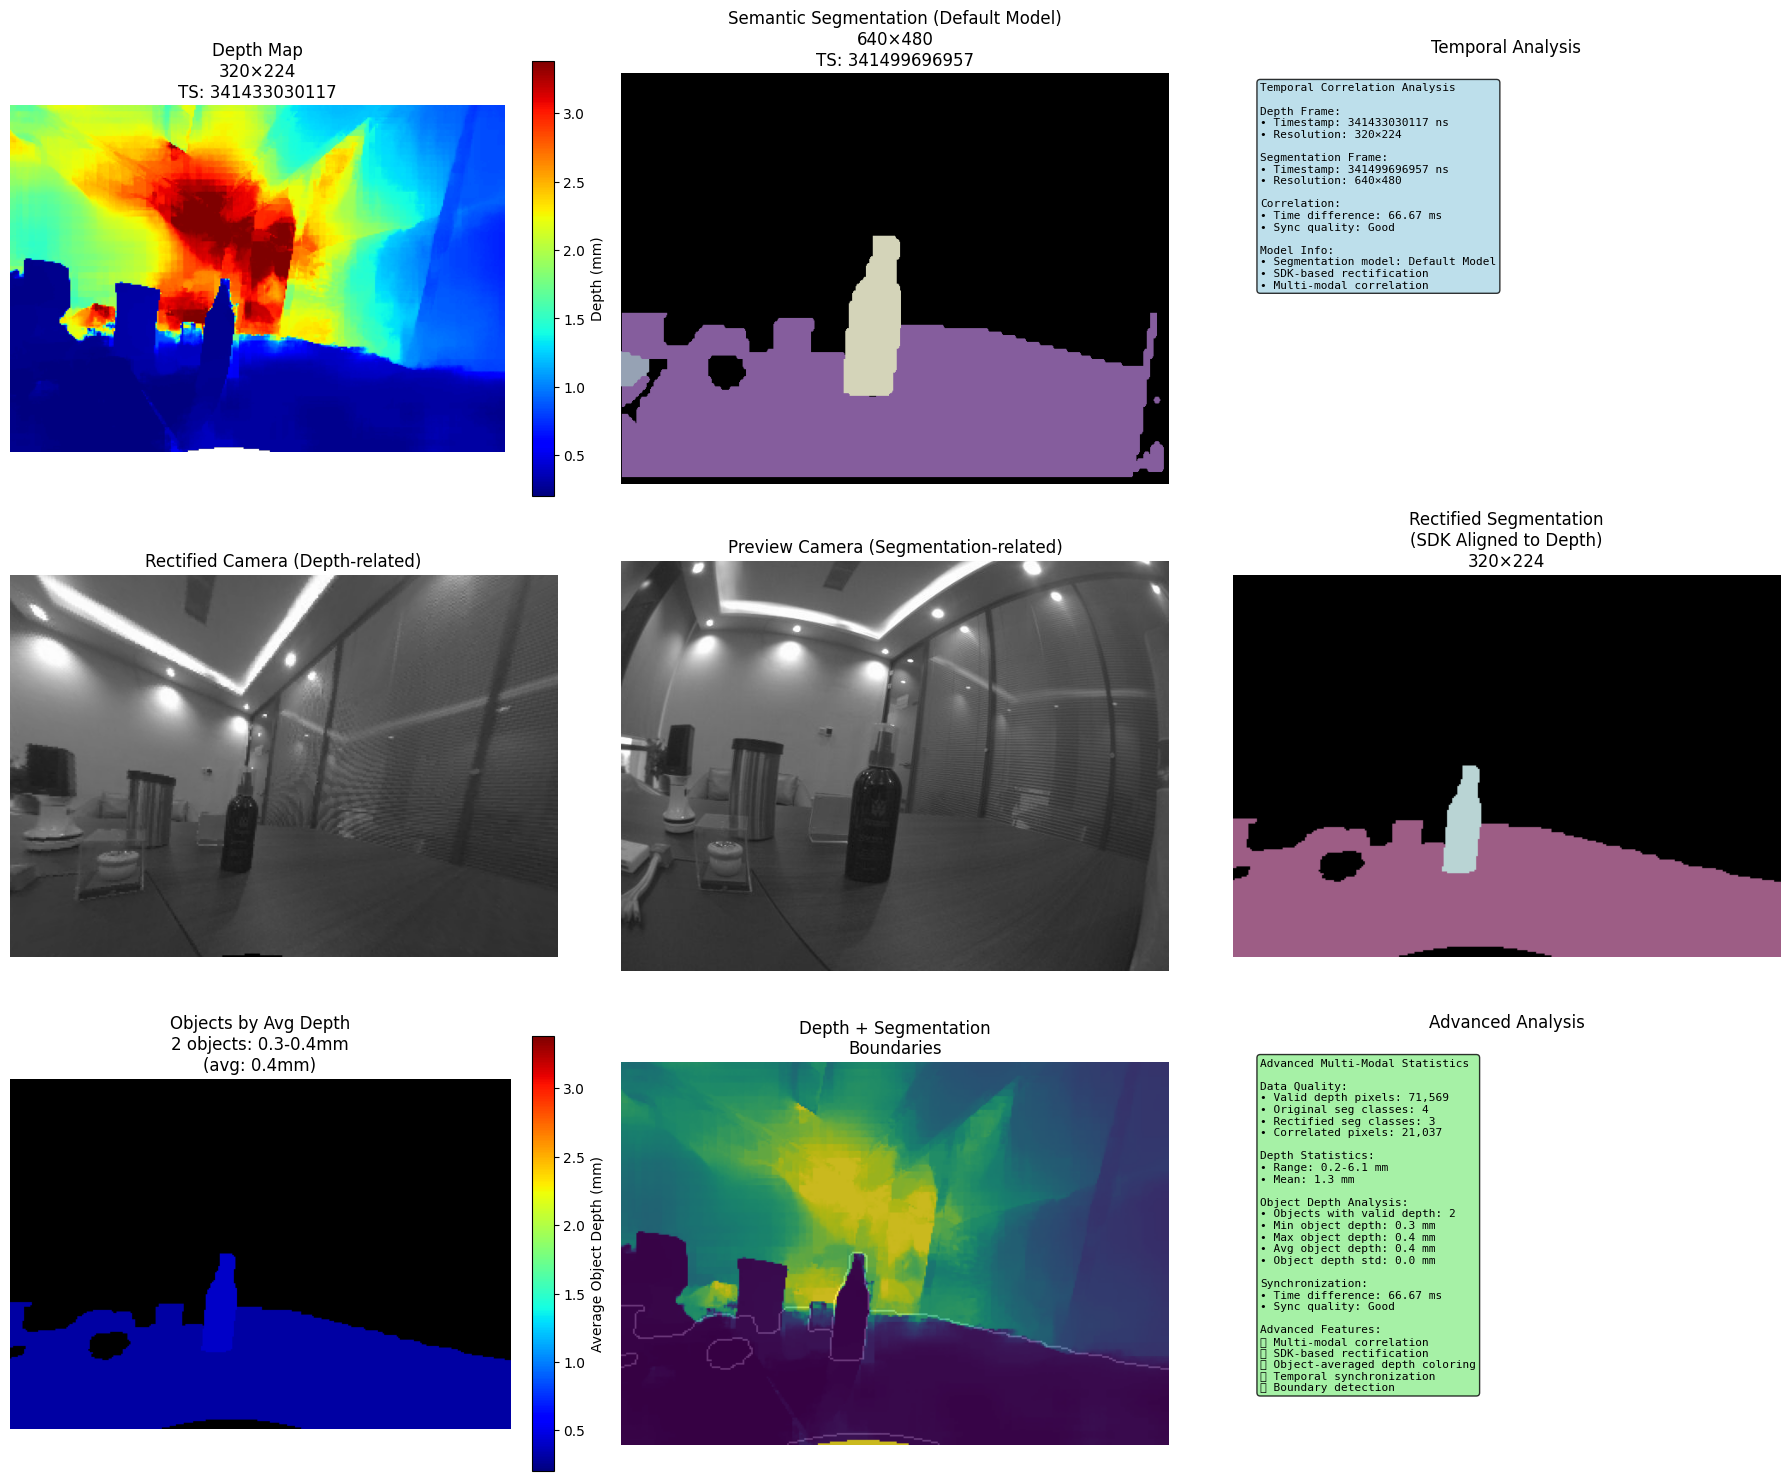

✅ Comprehensive multi-modal visualization completed!
🔍 This demonstrates Aurora's advanced Enhanced Imaging capabilities:
   • Multi-modal data correlation
   • SDK-based geometric rectification
   • Object-averaged depth-based coloring with depth legend
   • Temporal synchronization analysis
   • Advanced boundary detection


In [35]:
# Comprehensive Multi-Modal Visualization
if (depth_frame and seg_frame and depth_map is not None and seg_map is not None):
    try:
        print("🎨 Creating comprehensive multi-modal visualization...")
        
        fig, axes = plt.subplots(3, 3, figsize=(18, 15))
        
        # === ROW 1: Core Data + Timestamps ===
        
        # 1.1 Depth Map
        depth_vis = depth_map.copy().astype(np.float32)
        valid_mask = (depth_vis > 0) & np.isfinite(depth_vis)
        depth_vis[~valid_mask] = np.nan
        
        if np.any(valid_mask):
            valid_depths = depth_map[valid_mask]
            vmin, vmax = np.percentile(valid_depths, [2, 98])
            im1 = axes[0,0].imshow(depth_vis, cmap='jet', vmin=vmin, vmax=vmax)
            plt.colorbar(im1, ax=axes[0,0], fraction=0.046, label='Depth (mm)')
        else:
            axes[0,0].text(0.5, 0.5, 'No valid depth data', ha='center', va='center', transform=axes[0,0].transAxes)
        
        axes[0,0].set_title(f'Depth Map\n{depth_frame.width}×{depth_frame.height}\nTS: {depth_timestamp}')
        axes[0,0].axis('off')
        
        # 1.2 Colorized Segmentation
        if colorized_seg is not None:
            axes[0,1].imshow(cv2.cvtColor(colorized_seg, cv2.COLOR_BGR2RGB))
            model_type = "Alt Model" if sdk.enhanced_imaging.is_semantic_segmentation_alternative_model() else "Default Model"
        else:
            axes[0,1].imshow(seg_map, cmap='tab20')
            model_type = "Default Model"
        
        axes[0,1].set_title(f'Semantic Segmentation ({model_type})\n{seg_frame.width}×{seg_frame.height}\nTS: {seg_timestamp}')
        axes[0,1].axis('off')
        
        # 1.3 Temporal Analysis
        axes[0,2].axis('off')
        temporal_text = f"""Temporal Correlation Analysis

Depth Frame:
• Timestamp: {depth_timestamp} ns
• Resolution: {depth_frame.width}×{depth_frame.height}

Segmentation Frame:
• Timestamp: {seg_timestamp} ns
• Resolution: {seg_frame.width}×{seg_frame.height}

Correlation:
• Time difference: {time_diff_ms:.2f} ms
• Sync quality: {sync_quality}

Model Info:
• Segmentation model: {model_type}
• SDK-based rectification
• Multi-modal correlation"""
        
        axes[0,2].text(0.05, 0.95, temporal_text, transform=axes[0,2].transAxes,
                      verticalalignment='top', fontfamily='monospace', fontsize=8,
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        axes[0,2].set_title('Temporal Analysis')
        
        # === ROW 2: Camera Images + Rectified Segmentation ===
        
        # 2.1 Rectified Camera (Depth-related)
        if depth_camera_image and depth_camera_image.has_image_data():
            depth_cam_cv = depth_camera_image.to_opencv_image()
            if depth_cam_cv is not None:
                axes[1,0].imshow(cv2.cvtColor(depth_cam_cv, cv2.COLOR_BGR2RGB))
                axes[1,0].set_title('Rectified Camera (Depth-related)')
            else:
                axes[1,0].text(0.5, 0.5, 'Rectified camera\nconversion failed',
                              ha='center', va='center', transform=axes[1,0].transAxes)
                axes[1,0].set_title('Rectified Camera - Error')
        else:
            axes[1,0].text(0.5, 0.5, 'No rectified\ncamera available',
                          ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('Rectified Camera - N/A')
        axes[1,0].axis('off')
        
        # 2.2 Preview Camera (Segmentation-related)
        if seg_camera_preview is not None:
            axes[1,1].imshow(cv2.cvtColor(seg_camera_preview, cv2.COLOR_BGR2RGB))
            axes[1,1].set_title('Preview Camera (Segmentation-related)')
        else:
            axes[1,1].text(0.5, 0.5, 'No preview\ncamera available',
                          ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Preview Camera - N/A')
        axes[1,1].axis('off')
        
        # 2.3 Rectified Segmentation
        if rectified_seg_map is not None:
            try:
                if colors is not None:
                    rectified_colored = np.zeros((*rectified_seg_map.shape, 3), dtype=np.uint8)
                    for class_id in range(min(len(colors), rectified_seg_map.max() + 1)):
                        mask = rectified_seg_map == class_id
                        if np.any(mask):
                            rectified_colored[mask] = colors[class_id]
                    axes[1,2].imshow(rectified_colored)
                else:
                    axes[1,2].imshow(rectified_seg_map, cmap='tab20')
                
                axes[1,2].set_title(f'Rectified Segmentation\n(SDK Aligned to Depth)\n{rectified_seg_map.shape[1]}×{rectified_seg_map.shape[0]}')
            except Exception as e:
                axes[1,2].text(0.5, 0.5, f'Rectified seg\nvisualization failed',
                              ha='center', va='center', transform=axes[1,2].transAxes)
                axes[1,2].set_title('Rectified Segmentation - Error')
        else:
            axes[1,2].text(0.5, 0.5, 'No rectified\nsegmentation available',
                          ha='center', va='center', transform=axes[1,2].transAxes)
            axes[1,2].set_title('Rectified Segmentation - N/A')
        axes[1,2].axis('off')
        
        # === ROW 3: Advanced Fusion Visualizations ===
        
        # 3.1 Object-Averaged Depth Coloring
        try:
            if rectified_seg_map is not None and np.any(valid_mask):
                print("🎨 Computing average depth for each segmentation object...")
                
                seg_for_coloring = rectified_seg_map
                if seg_for_coloring.shape != depth_map.shape:
                    seg_for_coloring = cv2.resize(seg_for_coloring, (depth_frame.width, depth_frame.height), 
                                                 interpolation=cv2.INTER_NEAREST)
                
                # Create output image for object-averaged depth coloring
                object_depth_colored = np.zeros((*depth_map.shape, 3), dtype=np.uint8)
                
                # Get unique segmentation labels (excluding background)
                unique_labels = np.unique(seg_for_coloring)
                unique_labels = unique_labels[unique_labels > 0]  # Remove background (0)
                
                # Calculate depth range for normalization
                valid_depths_color = depth_map[valid_mask]
                depth_min = np.percentile(valid_depths_color, 2)
                depth_max = np.percentile(valid_depths_color, 98)
                
                print(f"   Processing {len(unique_labels)} segmentation objects...")
                
                # Process each segmentation object
                object_depths = {}
                for label_id in unique_labels:
                    # Get mask for this object
                    object_mask = seg_for_coloring == label_id
                    
                    # Get depth values for this object (only valid depths)
                    object_valid_mask = object_mask & valid_mask
                    
                    if np.any(object_valid_mask):
                        # Calculate average depth for this object
                        object_depth_values = depth_map[object_valid_mask]
                        avg_depth = np.mean(object_depth_values)
                        object_depths[label_id] = avg_depth
                        
                        # Normalize average depth to 0-1 range
                        normalized_depth = np.clip((avg_depth - depth_min) / (depth_max - depth_min), 0, 1)
                        
                        # Get color from jet colormap for this average depth
                        jet_colormap = plt.cm.jet(normalized_depth)[:3]  # RGB values 0-1
                        object_color = (np.array(jet_colormap) * 255).astype(np.uint8)
                        
                        # Color the entire object with its average depth color
                        object_depth_colored[object_mask] = object_color[[2, 1, 0]]  # Convert RGB to BGR for OpenCV
                
                # Convert BGR to RGB for matplotlib
                object_depth_colored_rgb = cv2.cvtColor(object_depth_colored, cv2.COLOR_BGR2RGB)
                im_obj = axes[2,0].imshow(object_depth_colored_rgb)
                
                # Add depth colorbar for object-averaged depth visualization
                if object_depths:
                    # Create a colorbar showing the depth range used for coloring
                    from matplotlib.colors import Normalize
                    from matplotlib.cm import ScalarMappable
                    
                    norm = Normalize(vmin=depth_min, vmax=depth_max)
                    sm = ScalarMappable(norm=norm, cmap='jet')
                    sm.set_array([])
                    
                    cbar = plt.colorbar(sm, ax=axes[2,0], fraction=0.046, pad=0.04)
                    cbar.set_label('Average Object Depth (mm)', fontsize=10)
                    
                    # Create title with object count and depth info
                    min_obj_depth = min(object_depths.values())
                    max_obj_depth = max(object_depths.values())
                    avg_obj_depth = np.mean(list(object_depths.values()))
                    title_text = f'Objects by Avg Depth\n{len(object_depths)} objects: {min_obj_depth:.1f}-{max_obj_depth:.1f}mm\n(avg: {avg_obj_depth:.1f}mm)'
                else:
                    title_text = 'Objects by Avg Depth\nNo valid objects found'
                
                axes[2,0].set_title(title_text)
                print(f"   ✅ Colored {len(object_depths)} objects by average depth")
                
            else:
                axes[2,0].text(0.5, 0.5, 'No rectified segmentation\nor depth data',
                              ha='center', va='center', transform=axes[2,0].transAxes)
                axes[2,0].set_title('Object-Averaged Depth Coloring - No Data')
        except Exception as e:
            axes[2,0].text(0.5, 0.5, f'Object depth coloring\nfailed:\n{str(e)[:30]}...',
                          ha='center', va='center', transform=axes[2,0].transAxes)
            axes[2,0].set_title('Object-Averaged Depth Coloring - Error')
            print(f"   ❌ Object depth coloring failed: {e}")
        axes[2,0].axis('off')
        
        # 3.2 Depth + Segmentation Boundaries
        try:
            if rectified_seg_map is not None and np.any(valid_mask):
                seg_for_overlay = rectified_seg_map
                if seg_for_overlay.shape != depth_map.shape:
                    seg_for_overlay = cv2.resize(seg_for_overlay, (depth_frame.width, depth_frame.height),
                                                interpolation=cv2.INTER_NEAREST)
                
                # Normalize depth for background
                depth_normalized = np.clip((depth_map - depth_min) / (depth_max - depth_min), 0, 1)
                depth_normalized = (depth_normalized * 255).astype(np.uint8)
                depth_base = cv2.applyColorMap(depth_normalized, cv2.COLORMAP_VIRIDIS)
                
                # Create segmentation boundaries
                seg_edges = cv2.Canny(seg_for_overlay.astype(np.uint8), 1, 2)
                seg_edges_colored = cv2.cvtColor(seg_edges, cv2.COLOR_GRAY2BGR)
                seg_edges_colored[seg_edges > 0] = [255, 255, 255]  # White edges
                
                # Combine depth background with segmentation edges
                combined = cv2.addWeighted(depth_base, 0.8, seg_edges_colored, 0.2, 0)
                combined_rgb = cv2.cvtColor(combined, cv2.COLOR_BGR2RGB)
                
                axes[2,1].imshow(combined_rgb)
                axes[2,1].set_title('Depth + Segmentation\nBoundaries')
            else:
                axes[2,1].text(0.5, 0.5, 'No data for overlay',
                              ha='center', va='center', transform=axes[2,1].transAxes)
                axes[2,1].set_title('Depth + Segmentation - No Data')
        except Exception as e:
            axes[2,1].text(0.5, 0.5, f'Overlay failed:\n{str(e)[:20]}...',
                          ha='center', va='center', transform=axes[2,1].transAxes)
            axes[2,1].set_title('Depth + Segmentation - Error')
        axes[2,1].axis('off')
        
        # 3.3 Advanced Statistics
        axes[2,2].axis('off')
        
        try:
            unique_classes_orig = len(np.unique(seg_map))
            unique_classes_rect = len(np.unique(rectified_seg_map)) if rectified_seg_map is not None else 0
            
            corr_pixels = 0
            if rectified_seg_map is not None:
                rect_seg_resized = rectified_seg_map
                if rect_seg_resized.shape != depth_map.shape:
                    rect_seg_resized = cv2.resize(rectified_seg_map, (depth_frame.width, depth_frame.height),
                                                 interpolation=cv2.INTER_NEAREST)
                corr_pixels = np.sum(valid_mask & (rect_seg_resized > 0))
            
            # Add object depth statistics if available
            object_stats_text = ""
            if 'object_depths' in locals() and object_depths:
                depths_list = list(object_depths.values())
                object_stats_text = f"""

Object Depth Analysis:
• Objects with valid depth: {len(object_depths)}
• Min object depth: {min(depths_list):.1f} mm
• Max object depth: {max(depths_list):.1f} mm
• Avg object depth: {np.mean(depths_list):.1f} mm
• Object depth std: {np.std(depths_list):.1f} mm"""
            
            stats_text = f"""Advanced Multi-Modal Statistics

Data Quality:
• Valid depth pixels: {np.sum(valid_mask):,}
• Original seg classes: {unique_classes_orig}
• Rectified seg classes: {unique_classes_rect}
• Correlated pixels: {corr_pixels:,}

Depth Statistics:
• Range: {valid_depths.min():.1f}-{valid_depths.max():.1f} mm
• Mean: {valid_depths.mean():.1f} mm{object_stats_text}

Synchronization:
• Time difference: {time_diff_ms:.2f} ms
• Sync quality: {sync_quality}

Advanced Features:
✅ Multi-modal correlation
✅ SDK-based rectification
✅ Object-averaged depth coloring
✅ Temporal synchronization
✅ Boundary detection"""
            
            axes[2,2].text(0.05, 0.95, stats_text, transform=axes[2,2].transAxes,
                          verticalalignment='top', fontfamily='monospace', fontsize=8,
                          bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
            axes[2,2].set_title('Advanced Analysis')
        except Exception as e:
            axes[2,2].text(0.5, 0.5, f'Statistics failed:\n{str(e)[:30]}...',
                          ha='center', va='center', transform=axes[2,2].transAxes)
            axes[2,2].set_title('Advanced Analysis - Error')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Comprehensive multi-modal visualization completed!")
        print("🔍 This demonstrates Aurora's advanced Enhanced Imaging capabilities:")
        print("   • Multi-modal data correlation")
        print("   • SDK-based geometric rectification")
        print("   • Object-averaged depth-based coloring with depth legend")
        print("   • Temporal synchronization analysis")
        print("   • Advanced boundary detection")
        
    except Exception as e:
        print(f"❌ Visualization error: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Missing required data for advanced visualization")
    print("💡 Please run the data capture step first (previous cell)")

## Step 3: Cleanup

In [ ]:
try:
    print("🔄 Cleaning up...")
    
    # Disable subscriptions
    sdk.controller.set_enhanced_imaging_subscription(ENHANCED_IMAGE_TYPE_DEPTH, False)
    sdk.controller.set_enhanced_imaging_subscription(ENHANCED_IMAGE_TYPE_SEMANTIC_SEGMENTATION, False)
    
    # Disconnect
    sdk.disconnect()
    sdk.release()
    
    print("✅ Advanced Enhanced Imaging analysis completed!")
    print("📊 Summary of captured data:")
    
    if 'depth_frame' in globals() and depth_frame:
        print(f"   • Depth: {depth_frame.width}x{depth_frame.height}")
    if 'seg_frame' in globals() and seg_frame:
        print(f"   • Segmentation: {seg_frame.width}x{seg_frame.height}")
    if 'rectified_seg_map' in globals() and rectified_seg_map is not None:
        print(f"   • Rectified segmentation: {rectified_seg_map.shape[1]}x{rectified_seg_map.shape[0]}")
    if 'time_diff_ms' in globals():
        print(f"   • Temporal sync: {time_diff_ms:.2f}ms ({sync_quality})")
    
except Exception as e:
    print(f"⚠️ Cleanup warning: {e}")

## Summary

This advanced notebook demonstrated sophisticated Enhanced Imaging capabilities:

### **Advanced Features Covered**

1. ✅ **Advanced Multi-Modal Correlation** - Temporal synchronization and pixel-level mapping
2. ✅ **SDK-Based Rectification** - Geometric alignment using `calc_depth_camera_aligned_segmentation_map`
3. ✅ **Multi-Modal Camera Correlation** - Rectified vs preview camera comparison
4. ✅ **Object-Averaged Depth Coloring** - Segmented objects colored by their average depth values
5. ✅ **Advanced Analytics** - Comprehensive statistical analysis and boundary detection

### **Key Technical Achievements**

- **Geometric Precision**: SDK-aligned rectified segmentation ensures pixel-perfect correlation
- **Temporal Accuracy**: Millisecond-level synchronization analysis
- **Multi-Modal Fusion**: Advanced visualization techniques combining depth, segmentation, and camera data
- **3D Semantic Understanding**: Depth-based coloring provides 3D context to semantic information
- **Professional Visualization**: Publication-quality visualizations with proper legends and scales

### **Applications**

These advanced techniques enable:

- **Precision Robotics**: Exact 3D object localization and manipulation
- **Advanced Navigation**: Obstacle detection with depth and semantic context
- **Quality Inspection**: Multi-modal defect detection and classification
- **Augmented Reality**: Precise AR content placement using semantic + depth
- **Scientific Analysis**: Research-grade multi-modal data correlation

### **Prerequisites and Model Management**

This notebook builds on the fundamentals from `04_enhanced_imaging.ipynb`, which covers:
- Basic Enhanced Imaging setup and usage
- Alternative segmentation model switching and comparison
- Model selection for different applications

### **Next Steps**

Continue exploring Aurora's capabilities:

- **[VSLAM Integration](03_vslam_mapping_and_tracking.ipynb)** - Combine Enhanced Imaging with 3D mapping
- **[LiDAR Fusion](tutorials/)** - Multi-sensor fusion with LiDAR data
- **Custom Applications** - Build specialized multi-modal applications

This represents the cutting edge of Aurora's AI-powered perception capabilities!